# Parte 2: Baseline (Regresión Logística).


En esta parte se implementa un modelo de regresión logística como baseline para el problema de clasificación de tweets relacionados a desastres naturales. Se utilizan características numéricas, categóricas y de texto procesadas previamente.

En esta parte me centro en conseguir un modelo rápido y sencillo de interpretar, dejando modelos más complejos para la parte 3. \
El paso a paso del proceso de entrenamiento está más detallado en la parte 3. Como este fue el primer modelo que entrené tuve bastante prueba y error, por lo que terminé arreglando el proceso general luego de terminar la parte 3 y obtuve un pipeline similar al de los modelos más complejos.


## Respuestas a las preguntas del enunciado:
- ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)\

El mejor score de validación obtenido fue de **0.73800** en Cross Validation y de **0.75867** en el set de validación (20% del train set original). \
Considero el segundo score como más representativo del desempeño real del modelo, ya que en CV se entrena y evalúa en múltiples folds, lo que puede llevar a un sobreajuste a los datos de entrenamiento.

- Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

El score obtenido en la competencia fue de **0.76769**.

- ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar

Esta pregunta está respondida en la sección [Importancia de features](#Importancia-de-features) más abajo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

SEED = 42
np.random.seed(SEED)


In [2]:
train_path = 'data/train.csv'
df = pd.read_csv(train_path)
print('train shape:', df.shape)


train shape: (7613, 5)


## Preparación datos para entrenamiento y validación

A continuación defino las características mostradas en la parte 1.

In [3]:
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].apply(clean_text)
df['location'] = df['location'].fillna('no_location_contained')

df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))
df['has_hashtag'] = df['num_hashtags'].apply(lambda x: 1 if x > 0 else 0)
df['has_mention'] = df['num_mentions'].apply(lambda x: 1 if x > 0 else 0)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)
df['all_caps_count'] = df['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())).fillna(0)

analyzer = SentimentIntensityAnalyzer()

def vader_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

scores = [vader_scores(t) for t in df['text'].astype(str).tolist()]
scores_df = pd.DataFrame(scores)

df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)

In [4]:
num_features = [
    'text_len', 'word_count', 'mean_word_len',
    'num_hashtags', 'num_mentions', 'disaster_terms_count',
    'all_caps_count', 
    'neg', 'neu', 'pos', 'compound'
]
cat_features = ['location', 'keyword']
bool_features = ['has_url', 'has_hashtag', 'has_mention', 'location_mentioned']
emb_features = ['text_clean']
X = df[num_features + cat_features + bool_features + emb_features]
y = df['target'].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape)


Train shape: (6090, 18) Val shape: (1523, 18)


## Encoding + búsqueda de hiperparámetros con GridSearchCV

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


preprocessor = ColumnTransformer(
    transformers=[
        # ('nombre', transformador, columnas_a_aplicar)
        
        ('emb', TfidfVectorizer(max_features=100, stop_words='english'), 'text_clean'),
        
        ('kyw', TargetEncoder(random_state=SEED), ['keyword']),
        
        ('loc', TargetEncoder(random_state=SEED), ['location']),
        
        ('other', 'passthrough', num_features + bool_features),
    ],
    remainder='drop'
)

base_line_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('baseline', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED))
    ]
)

In [6]:
hparams = {
    'baseline__C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
    'baseline__penalty': ['l1', 'l2', None],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
grid = GridSearchCV(base_line_pipeline, hparams, scoring='f1', cv=cv, n_jobs=1, verbose=0)

grid.fit(X_train, y_train)

c:\Users\Patricio\miniconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Patricio\miniconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Patricio\miniconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\P

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'baseline__C': [0.01, 0.05, ...], 'baseline__penalty': ['l1', 'l2', ...]}"
,scoring,'f1'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('emb', ...), ('kyw', ...), ...]"


In [7]:
best_bl = grid.best_estimator_
vectorizer = best_bl.named_steps['preprocessor'].named_transformers_['emb']
model = best_bl.named_steps['baseline']
print('Mejores hiper parametros:', grid.best_params_)
print('Mejor F1 en CV:', grid.best_score_)

y_val_pred = best_bl.predict(X_val)
print('F1 en validación:', f1_score(y_val, y_val_pred))

Mejores hiper parametros: {'baseline__C': 0.25, 'baseline__penalty': 'l2'}
Mejor F1 en CV: 0.7380042354347581
F1 en validación: 0.7586726998491704


## Importancia de features

Tomo los coeficientes del modelo entrenado (`coef_`) para analizar la importancia de las features.

Puede verse que la mayoría de las features más importantes son las relacionadas al texto (TF-IDF), aunque también pueden identificarse algunas features booleanas y numéricas relevantes.

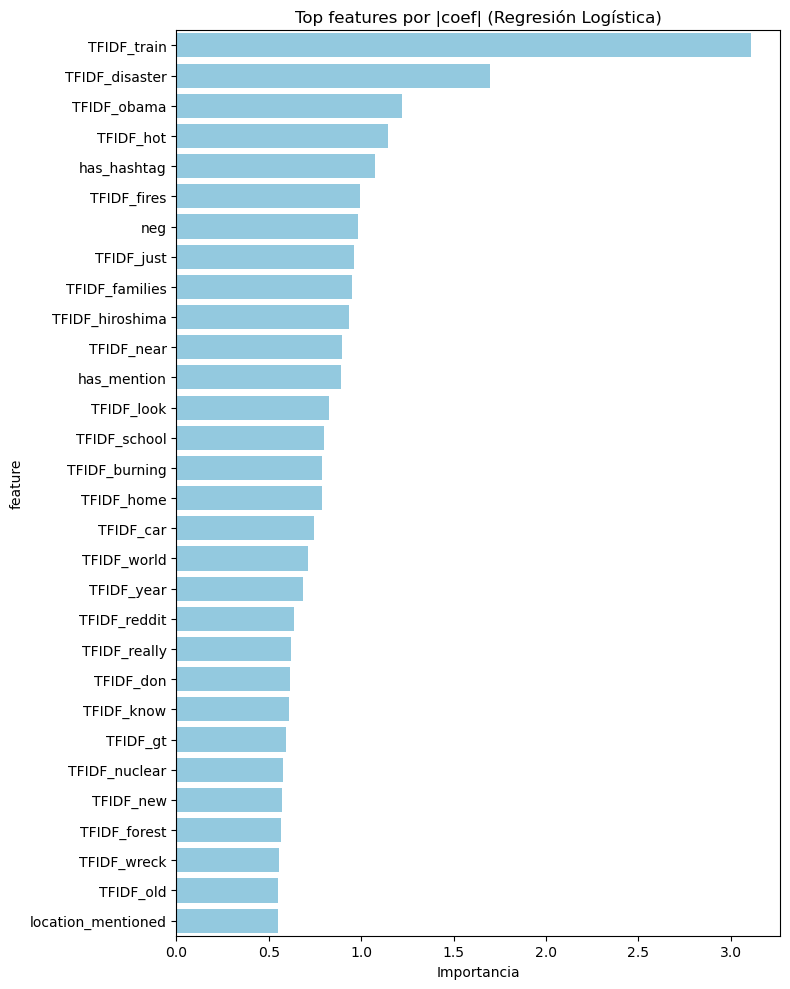

In [8]:
tfidf_col_names = [f"TFIDF_{c}" for c in vectorizer.get_feature_names_out()]
feature_names_tab = num_features + ['location_enc', 'keyword_enc'] + bool_features + tfidf_col_names
# Coefs del mejor_clf (coef_ corresponde a todas las features incl. embeddings)
coefs = model.coef_[0]
# Tomamos coeficientes relativos a las features tabulares (al inicio)
n_tab = len(feature_names_tab)
tab_coefs = coefs[:n_tab]
imp_df = pd.DataFrame({'feature': feature_names_tab, 'coef_abs': np.abs(tab_coefs), 'coef': tab_coefs})
imp_df = imp_df.sort_values('coef_abs', ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(x='coef_abs', y='feature', data=imp_df, color='skyblue')
plt.title('Top features por |coef| (Regresión Logística)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()


## Predicción sobre el set de Test

In [9]:
test_path = 'data/test.csv'
df_test = pd.read_csv(test_path)

In [10]:
df_test['text_clean'] = df_test['text'].apply(clean_text)
df_test['keyword'] = df_test['keyword'].fillna('no_keyword_contained')
df_test['location'] = df_test['location'].apply(clean_text)
df_test['location'] = df_test['location'].fillna('no_location_contained')

df_test['word_count'] = df_test['text_clean'].apply(lambda s: len(s.split()))
df_test['text_len'] = df_test['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df_test['mean_word_len'] = df_test.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df_test['num_hashtags'] = df_test['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df_test['num_mentions'] = df_test['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df_test['has_url'] = df_test['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))
df_test['has_hashtag'] = df_test['num_hashtags'].apply(lambda x: 1 if x > 0 else 0)
df_test['has_mention'] = df_test['num_mentions'].apply(lambda x: 1 if x > 0 else 0)
df_test['location_mentioned'] = df_test.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)

disaster_terms = df_test['keyword'].dropna().unique().tolist()

df_test['disaster_terms_count'] = df_test['text_clean'].apply(count_terms)
df_test['all_caps_count'] = df_test['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())).fillna(0)

scores = [vader_scores(t) for t in df_test['text'].astype(str).tolist()]
scores_df_test = pd.DataFrame(scores)

df_test = pd.concat([df_test.reset_index(drop=True), scores_df_test.reset_index(drop=True)], axis=1)


In [11]:
test_pred = best_bl.predict(df_test)

In [12]:
submission = pd.DataFrame({'id': df_test['id'], 'target': test_pred})
submission.to_csv('baseline_submission.csv', index=False)